In [4]:
import yfinance as yf
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage

In [5]:
# Loading environment variables
load_dotenv()

True

In [6]:
# --- 1. Define the Agent State ---
# The state includes a message history, user's portfolio and cash balance
class PortfolioState(TypedDict):
    messages: Annotated[list, add_messages]
    portfolio: dict
    cash_balance: float

In [16]:
# --- 2. Define the Tools ---
@tool
def get_stock_price(symbol: str) -> float:
    """
    Return the current price of a stock given its stock symbol (e.g., 'AAPL', 'MSFT'). 
    The model should look up the symbol if the user provides a company name (e.g., 'Apple').
    """
    print('Getting the stock price')
    try:
        ticker = yf.Ticker(symbol)
        # Fetch the current price
        current_price = ticker.history(period="1d")['Close'].iloc[-1]
        return float(current_price)
    except IndexError:
        return f"Error: Could not retrieve price for {symbol}. It might be an invalid symbol."
    except Exception as e:
        return f"An error occurred: {e}"

@tool
def deposit_cash(amount: float) -> str:
    """
    Depositing the given cash amount into the portfolio.
    """
    print('Depositing money in the tools function')
    if amount <= 0:
        return "Deposit amount must be a positive number."
    # Using interrupt to require human confirmation for a deposit
    decision = interrupt(f"Approve depositing ${amount:.2f}? yes/no")
    if decision.lower() == "yes":
        # Include amount in the return message for the update_state_node
        return f"Simulating a deposit of ${amount:.2f}."
    return "Deposit declined."

@tool
def buy_stock(symbol: str, quantity: int) -> str:
    """
    Buying the given quantity of stock for the given company (e.g., 'AAPL', 'MSFT'). 
    If the symbol is not given, look up the symbol for the company (e.g., 'Apple').
    """
    print('Buying stock in the tools fucntion')
    
    # 1. Get Price and Handle Error
    price_or_error = get_stock_price(symbol)
    if isinstance(price_or_error, str):
        return price_or_error
    
    total_cost = price_or_error * quantity

    # 3. Human Interrupt
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_cost:.2f}? yes/no")
    if decision.lower() == "yes":
        # Include cost for update_state_node
        return f"You bought {quantity} shares of {symbol} for a total price of {total_cost:.2f}."
    return "Buy order declined."

@tool
def sell_stock(symbol: str, quantity: int) -> str:
    """
    Selling the given quantity of stock for the given company (e.g., 'AAPL', 'MSFT').
    if the symbol is not given, look up the symbol for the company (e.g., 'Apple').
    """
    print('Selling stock in the tools function')

    # 2. Get Price for Interrupt Message
    price_or_error = get_stock_price(symbol)
    if isinstance(price_or_error, str):
        return price_or_error
        
    total_cost = price_or_error * quantity

    # 3. Human Interrupt
    decision = interrupt(f"Approve selling {quantity} shares of {symbol} for an estimated ${total_cost:.2f}? yes/no")
    if decision.lower() == "yes":
        # Include proceeds for update_state_node
        return f"Simulating a sell order for {quantity} shares of {symbol} with proceeds of {total_cost:.2f}."
    return "Sell order declined."


tools = [get_stock_price, deposit_cash, buy_stock, sell_stock]

In [17]:
# --- 3. Initialize the LLM and bind tools ---
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

E0000 00:00:1761135138.111018   74533 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [18]:
# --- 4. Define the Nodes of the Graph ---

def chatbot_node(state: PortfolioState) -> PortfolioState:
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

def update_state_node(state: PortfolioState) -> PortfolioState:
    messages = state["messages"]
    tool_msg = messages[-1]   # ToolMessage (output)
    ai_msg = messages[-2]     # AIMessage (tool call)

    tool_name = tool_msg.name
    tool_args = ai_msg.tool_calls[0]["args"]

    updated_state = state.copy()
    print('Updating the state in the update node')
    
    # 1. Check if the transaction was declined by the human interrupt
    if "declined" in tool_msg.content.lower() or "error" in tool_msg.content.lower():
        print(f"Transaction for {tool_name} was declined or failed. State not updated.")
        return state # Return the original state without changes

    # 2. Update state based on successful transaction
    if tool_name == 'deposit_cash':
        print('update cash in the state')
        amount = tool_args["amount"]
        updated_state["cash_balance"] = state.get("cash_balance", 0.0) + amount
        print(f"State updated: Deposited ${amount:.2f}")

    elif tool_name == 'buy_stock':
        symbol = tool_args["symbol"]
        quantity = tool_args["quantity"]
        
        # Extract total cost from the tool's return message (a simple string search)
        price_or_error = get_stock_price(symbol)
        if isinstance(price_or_error, str):
            return price_or_error
            
        total_cost = price_or_error * quantity
        
        updated_portfolio = state.get("portfolio", {}).copy()
        updated_portfolio[symbol] = updated_portfolio.get(symbol, 0) + quantity

        updated_state["portfolio"] = updated_portfolio
        updated_state["cash_balance"] = state.get("cash_balance", 0.0) - total_cost
        print(f'State updated: Bought {quantity} {symbol} for -${total_cost:.2f}')


    elif tool_name == 'sell_stock':
        symbol = tool_args["symbol"]
        quantity = tool_args["quantity"]
        
        # Extract total proceeds from the tool's return message
        price_or_error = get_stock_price(symbol)
        if isinstance(price_or_error, str):
            return price_or_error
            
        total_cost = price_or_error * quantity

        updated_portfolio = state.get("portfolio", {}).copy()
        
        # The eligibility check already passed, so we assume stock is available
        updated_portfolio[symbol] = updated_portfolio.get(symbol, 0) - quantity
        if updated_portfolio[symbol] <= 0:
            del updated_portfolio[symbol]

        updated_state["portfolio"] = updated_portfolio
        updated_state["cash_balance"] = state.get("cash_balance", 0.0) + total_cost
        print(f'State updated: Sold {quantity} {symbol} for +${total_cost:.2f}')

    return updated_state

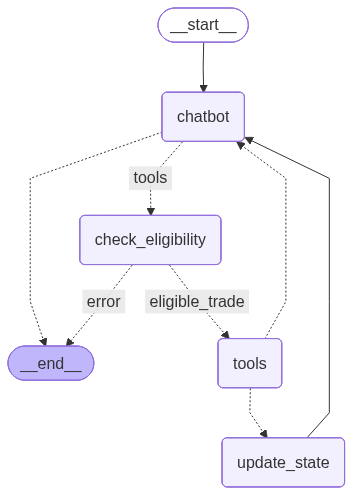

In [19]:
# --- 5. Define the necessary Router Functions --- 

def check_transaction_eligibility(state: PortfolioState) -> str:
    messages = state["messages"]
    ai_message = messages[-1] # This is now the LLM's tool-call request
    tool_calls = ai_message.tool_calls

    tc = tool_calls[0] # Assume one tool call per step
    tool_name = tc['name']
    
    if tool_name == 'buy_stock':
        symbol = tc['args']['symbol']
        quantity = tc['args']['quantity']
        price_or_error = get_stock_price(symbol)
        
        if isinstance(price_or_error, str) and "Error" in price_or_error:
            # Add error message to state for chatbot to report
            error_msg = f"Error: Could not check eligibility for {symbol}. {price_or_error}"
            # state["messages"].append({"role": "system", "content": error_msg})
            print(error_msg)
            return "error"
            
        total_cost = price_or_error * quantity
        
        if total_cost > state.get('cash_balance', 0.0):
            # Add insufficient funds message to state for chatbot to report
            error_msg = f"Transaction check failed: Insufficient funds. Buying {quantity} {symbol} would cost ${total_cost:.2f}, but you only have ${state.get('cash_balance', 0.0):.2f} cash."
            # state["messages"].append(HumanMessage(content=error_msg))
            print(error_msg)
            # return "insufficient_funds"
            return "error"
        else:
            return "eligible_trade"

    elif tool_name == 'sell_stock':
        symbol = tc['args']['symbol']
        quantity = tc['args']['quantity']
        
        if quantity > state.get('portfolio', {}).get(symbol, 0):
            # Add insufficient stock message to state for chatbot to report
            error_msg = f"Transaction check failed: Insufficient shares. You tried to sell {quantity} {symbol}, but you only own {state.get('portfolio', {}).get(symbol, 0)} shares."
            # state["messages"].append(HumanMessage(content=error_msg))
            print(error_msg)
            # return "insufficient_stock"
            return "error"
        else:
            return "eligible_trade"
            
    elif tool_name == 'deposit_cash':
        return 'eligible_trade'

    elif tool_name == "get_stock_price":
        return "eligible_trade"

    # return "no_tools"
    
def route_after_tool(state: PortfolioState) -> str:
    """
    Routes after the 'tools' node runs. Checks tool output message for success/failure.
    """
    messages = state["messages"]
    tool_output_msg = messages[-1].content
    ai_message = messages[-2]
    tool_name = ai_message.tool_calls[0]['name']
    
    # 1. Price Check: No state update needed.
    if tool_name == 'get_stock_price':
        return 'chatbot'
    
    # 2. Failure/Decline: No state update needed.
    if "failed" in tool_output_msg.lower() or "declined" in tool_output_msg.lower():
        return 'chatbot'
    
    # 3. Success (Deposit, Approved Buy, Approved Sell): Needs state update.
    return 'update_state' 
    

In [ ]:
# --- 6. Graph Builder ---

builder = StateGraph(PortfolioState)

builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", ToolNode(tools))
builder.add_node("update_state", update_state_node)
# The eligibility check node is for routing only, so we use an identity function.
builder.add_node("check_eligibility", lambda state: state) 


# 1. Edge from Start
builder.add_edge(START, 'chatbot')

# 2. Chatbot -> Router 1 (Initial Tool Check)
builder.add_conditional_edges(
    'chatbot', 
    tools_condition, 
    {
        "tools": "check_eligibility", 
        "__end__": END, 
    }
) 

# 3. Checker Node -> Router 2 (Eligibility Check)
# This conditional edge calls the string-returning function to decide the path.
builder.add_conditional_edges(
    'check_eligibility',
    check_transaction_eligibility, # The router function defined in Cell 6
    {
        # --- SUCCESS/PROCEED ROUTES (To tools node for execution/interrupt) ---
        'eligible_trade': 'tools',
        # 'deposit_route': 'tools',
        # 'price_route': 'tools',
        
        # --- FAILURE ROUTES (To chatbot for error message) ---
        # 'insufficient_stock': 'chatbot', 
        # 'insufficient_funds': END, 
        'error': END, 
        # 'no_tools': 'chatbot'
    }
)


# 4. Tools -> Router 3 (Post-Execution Check)
builder.add_conditional_edges('tools', route_after_tool,
                              {
                                  "chatbot": "chatbot",
                                  
                                  "update_state": "update_state",
                              })


# 5. Update State -> Chatbot (Loop Closure)
builder.add_edge('update_state', 'chatbot')


# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
# --- 7. Using the agent ---

config = {"configurable": {"thread_id": "chat_thread11"}}

# --- Interactive chatbot loop ---
state = {"messages": []}
print("Welcome to your stock chatbot! Type 'exit' to quit.\n")

while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break

    # Add user message
    state["messages"].append({"role": "user", "content": user_input})
    # state["messages"].append(HumanMessage(content=user_input))
    
    # Invoke the graph
    state = graph.invoke(state, config=config)

    if state.get("__interrupt__"):
        decision = input(f"{state['__interrupt__']} (yes/no): ")
        state = graph.invoke(Command(resume=decision), config=config)

    # Print the last AI message with content (ignore empty messages)
    # for msg in reversed(state["messages"]):
    #     if hasattr(msg, "content"):  # check if content exists and is not empty
    #         if msg.content: print(f"Agent: {msg.content}\n")
    #         break
    for msg in reversed(state["messages"]):
    # Check if the message is from the AI
        if msg.type == "ai":
            # If it has content, print it. (This skips AI messages that only contain tool calls)
            if msg.content:
                print(f"Agent: {msg.content}\n")
            
            # Break after finding the *last* AI message, even if it had no content
            break 
    
        # If we hit the user's message first, stop. No new AI message to print.
        if msg.type == "human":
            break

        

Welcome to your stock chatbot! Type 'exit' to quit.

getting stock price
Agent: The current price of MSFT stock is $517.66.

